# Bayesian methods for machine learning - Week 2

In [1]:
import os

import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

import gif

import torch
from torch.autograd import Variable
from torch.distributions.multivariate_normal import MultivariateNormal

from mixture import (
    sample_mu,
    sample_cov,
    sample_coefs,
    sample_mixture,
    sample_data,
    log_likelihood
)

from visualization import (
    plot_data,
    data_vs_estimation_frame
)

## Gaussian Mixture Models (GMM) 

### Fitting through numerical optimization

### Reminder

We want to maximize the log likelihood of the data:

$$
\theta_{MLE} = \underset{\theta}{\mathrm{argmax}} \sum_i^N \log \sum_k^K \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k)
$$

Given the set of parameters $\theta = \{ \pi_1, \pmb{\mu_1}, \pmb{\Sigma_1}, \ldots, \pi_K, \pmb{\mu_K}, \pmb{\Sigma_K} \}$, a set of i.i.d observations $\pmb{X} = \{\pmb{x_1}, \pmb{x_2}, \ldots, \pmb{x_N}\}$ and the corresponding latent variables $\pmb{Z} = \{ \pmb{z_1}, \pmb{z_2}, \ldots, \pmb{z_N} \}$.

Recall the following constraints must be satisfied for $\pi_k$:

- $\sum_i^M \pi_i = 1$
- $\pi_i \ge 0, \forall i = 1 \ldots M$

### Gradient descent

We will be estimating the Gaussian component parameters numerical optimization (e.g. Gradient descent). Note that, as we (unconstrained) update the parameters according to their gradient (wrt log likelihood), there are several undesirable situations that may occur:

- Components may collapse to specific points, which would result in covariance tending to zero (we will ignore this by now).
- Not all possible values of $\pmb{\Sigma_i}$ are possible, as matrices must be restricted to be invertible. We should force them to be positive-semi definitive [<sup>1</sup>](#fn1). However, this constraint is hard to maintain during an optimization process (you can read  [this](https://www.johndcook.com/blog/2012/06/13/matrix-condition-number). There are several options we can use here: restrict matrices to be diagonal [<sup>2</sup>](#fn2) and assume Gaussian components  are *spherical* (covariance is diagonal matrix multiplied by scalar) or add some constant to avoid singularity.

<hr>
<span id="fn1">[1] A matrix is positive semi-definite if all their eigenvalues are positive or zero</span> <br>
<span id="fn2">[2] For a matrix to be invertible, determinant must be non-zero. Since determinant of a diagonal matrix is the product of the values in the diagonal, we must ensure that non of the entries in the diagonal is zero.</span>
<hr>

## Load data

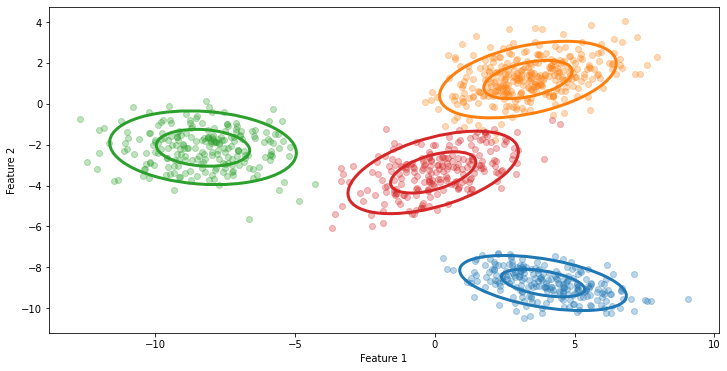

In [2]:
true_mus, true_sigmas, true_coefs = sample_mixture()
X, y = sample_data(mus=true_mus,
                   sigmas=true_sigmas,
                   coefs=true_coefs)

# Show data
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()

plot_data(X=X,
          y=y,
          mus=true_mus,
          sigmas=true_sigmas,
          ax=ax)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2');

We can compute the *groundtruth* likelihood as:

In [3]:
true_likelihood = log_likelihood(X=X,
                                 mus=true_mus,
                                 sigmas=true_sigmas,
                                 coefs=true_coefs)
print(f'Likelihood groundtruth of data: {true_likelihood}')

Likelihood groundtruth of data: -4452.384539397633


## Optimization process

We will be using numerical optimization using **Pytorch**. Note that instead of maximizing the log likelihood, we will minimize the negative log likelihood. We will add some very small constraint to avoid singularity (note that in some contexts this won't be enough to ensure we find a solution).

Let's define some initial parameters.

In [4]:
n_clusters, n_features = true_mus.shape[0], true_mus.shape[1]
min_init_std = 1
max_init_std = 10

learning_rate = 0.1
n_epochs = 250

Let's define parameters for debugging and visualization.

In [5]:
stats_interval = 25
plot_interval = 10
frames = []

Now let's proceed into the optimization loop:

In [6]:
def gaussian_pdf(X, mu, sigma):
    return MultivariateNormal(loc=mu,
                              covariance_matrix=sigma).log_prob(X).exp()


# Define parameters and their initial values
opt_coefs = Variable(torch.Tensor(sample_coefs(n_clusters)[None]),
                     requires_grad=True)

init_mus = np.stack([sample_mu(X.min(axis=0), X.max(axis=0))
                     for i in range(n_clusters)])
opt_mus = Variable(torch.Tensor(init_mus), requires_grad=True)

init_sigmas = np.stack([sample_cov(n_features) for i in range(n_clusters)])
opt_sigmas = Variable(torch.Tensor(init_sigmas), requires_grad=True)

# Define optimizer
opt = torch.optim.Adam([opt_coefs, opt_mus, opt_sigmas], lr=learning_rate)

# Train for some epochs
X_tensor = torch.Tensor(X)
likelihoods = []
for epoch in range(n_epochs):
    
    # Make sure constraints hold
    with torch.no_grad():
        # Avoid Singular matrices in Gaussians (non-invertible)
        opt_sigmas += 1e-25
    
    opt.zero_grad()

    # Get density for each of the mixtures
    pdfs = torch.stack(
        [
            gaussian_pdf(X=X_tensor,
                         mu=opt_mus[i],
                         sigma=opt_sigmas[i])
            for i in range(n_clusters)
        ],
        dim=1
    )
    
    # Estimate negative log likelihood
    softmax_coefs = torch.nn.Softmax(dim=-1)(opt_coefs)
    neg_log_likelihood = -torch.sum(
        torch.log(torch.mm(pdfs, torch.transpose(softmax_coefs, 0, 1)))
    )
    
    # Compute gradients and apply gradient descent
    neg_log_likelihood.backward()
    opt.step()
    
    if epoch % stats_interval == 0:
        print(f'Negative log likelihood at epoch {epoch}: {neg_log_likelihood.item()}')

    if epoch % plot_interval == 0:
        frame = data_vs_estimation_frame(
            X=X,
            y=y,
            true_mus=true_mus,
            true_sigmas=true_sigmas,
            mus=opt_mus.detach().numpy(),
            sigmas=opt_sigmas.detach().numpy(),
            figsize=(12, 5),
            epoch=epoch
        )
        frames.append(frame)

    # Keep track of likelihoods for plotting
    likelihoods.append(neg_log_likelihood.item())
    

# Make sure they sum to one
opt_coefs = torch.nn.Softmax(dim=-1)(opt_coefs)

Negative log likelihood at epoch 0: 14533.8818359375
Negative log likelihood at epoch 25: 5394.81494140625
Negative log likelihood at epoch 50: 4885.41064453125
Negative log likelihood at epoch 75: 4739.9111328125
Negative log likelihood at epoch 100: 4662.62451171875
Negative log likelihood at epoch 125: 4618.2890625
Negative log likelihood at epoch 150: 4591.6201171875
Negative log likelihood at epoch 175: 4575.21923828125
Negative log likelihood at epoch 200: 4557.7529296875
Negative log likelihood at epoch 225: 4537.66552734375


Let's plot the optimization progress with respect to time.

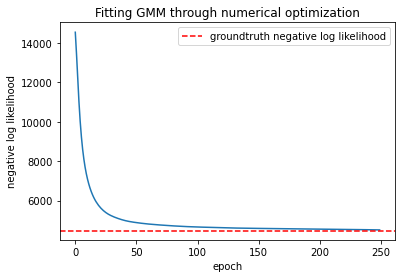

In [7]:
plt.plot(range(n_epochs), likelihoods)
plt.xlabel('epoch')
plt.ylabel('negative log likelihood')
plt.axhline(-true_likelihood,
            label='groundtruth negative log likelihood',
            color='red',
            linestyle='--')
plt.title('Fitting GMM through numerical optimization');
plt.legend()

We see that, after several epochs, it converges. We converge to a value close to the groundtruth one. However, note that is is very unlikely that we reach that point as we are making assumptions (i.e. mixture components are spherical) which we know are not probably true.

Let's compare the estimated parameters with the groundtruth:

In [8]:
print(
    f'''
Estimated weights: \n{opt_coefs.detach().numpy()}
Real weights: \n{true_coefs}

Estimated centers: \n{opt_mus.detach().numpy()}
Real centers: \n{true_mus}

Estimated sigmas: \n{opt_sigmas.detach().numpy()}
Real sigmas: \n{true_sigmas}
    '''
)


Estimated weights: 
[[0.21919867 0.23572275 0.3165326  0.22854592]]
Real weights: 
[0.24023278 0.31508254 0.21823632 0.22644836]

Estimated centers: 
[[-8.333329   -2.155572  ]
 [ 3.9452472  -8.760877  ]
 [ 3.4128122   1.2941357 ]
 [ 0.10291776 -3.2222843 ]]
Real centers: 
[[ 3.87359054 -8.76566015]
 [ 3.33223195  1.18417874]
 [-8.29778754 -2.15161887]
 [-0.05844945 -3.35701851]]

Estimated sigmas: 
[[[ 2.883005   -0.5344329 ]
  [-0.07367013  0.8502079 ]]

 [[ 5.7960424   0.39342588]
  [-2.0647244   1.1726428 ]]

 [[ 2.4500237  -0.16124664]
  [ 0.50058424  0.8485396 ]]

 [[ 2.9355302   0.3603195 ]
  [ 0.41912135  1.4216163 ]]]
Real sigmas: 
[[[ 2.22368781 -0.46692735]
  [-0.46692735  0.4545174 ]]

 [[ 2.50008149  0.62752786]
  [ 0.62752786  0.87694685]]

 [[ 2.79125064 -0.20990057]
  [-0.20990057  0.81232486]]

 [[ 2.32688166  0.77814247]
  [ 0.77814247  1.01659411]]]
    


Note that there is an *identifiability* problem, as there are $K!$ ways to assign the estimated parameters into the $K$ components. However, it is easy to map each estimated component to each groundtruth component.

We can visualize the Gaussian components at different time frames of the optimization process.

In [9]:
animation_path = os.path.join('media', 'gmm_optimization.gif')

if not os.path.isfile(animation_path):
    gif.save(frames, animation_path, duration=100)

![SegmentLocal](media/gmm_optimization.gif )

We found two main problems using optimization for fitting a Gaussian Mixture Model:

- Training can be slow and unstable using gradient descent.
- Constraints can be hard to maintain during optimization or force us to relax the problem.

Even though we did quite well, we can **exploit the structure of the problem** to solve it in a better and **more efficient** way though the **Expectation Maximization (EM) algorithm**.

## Future work

- [ ] Use data classes for Gaussian components to avoid passing so many arguments.
- [ ] Check convergence during training